In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Functions

In [60]:
def fill_missing_values_with_interpolation(df, method='linear', limit=None, inplace=True):
    """
    Fill missing values in a DataFrame using interpolation.

    Parameters:
    df (pd.DataFrame): The DataFrame containing missing values.
    method (str): The interpolation method to use. Options include 'linear', 'time', 'index', 'values', 'pad', 'nearest', 'polynomial', 'spline'.
                  Default is 'linear'.
    limit (int): Maximum number of consecutive NaNs to fill. Must be greater than 0. Default is None (no limit).
    inplace (bool): If True, do the operation in place. Default is False.

    Returns:
    pd.DataFrame: DataFrame with missing values filled.
    """
    if inplace:
        df.interpolate(method=method, limit=limit, inplace=True)
        return df
    else:
        return df.interpolate(method=method, limit=limit)

# DATASET Exploration

## Dataset Reading

In [61]:
df_energy = pd.read_csv('dataset/energy_dataset.csv')
df_weather = pd.read_csv('dataset/weather_features.csv')

## Energy dataset

We decided to drop some column because there is no collected data in them and they are variables that we cannot fill by ourself because they must be collected with a "tool": 
1. generation hydro pumped storage aggregated 
2. forecast wind offshore eday ahead

In [62]:
df_energy = df_energy.drop(columns=['generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead'])

In [63]:
# energy_corr = df_energy.drop(columns=['time'])
# corr_energy = energy_corr.corr()

# plt.figure(figsize=(20, 16))
# sns.heatmap(corr_energy, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Correlation Heatmap')
# plt.show()

We decided to drop features that have not correlation with any of other features, so they useless for our analysis.
1. 'generation fossil coal-derived gas'
2. 'generation fossil oil shale', 
3. 'generation fossil peat', 
4. 'generation geothermal', 
6. 'generation marine', 
7. 'generation wind offshore', 

We decided to drop features that have collinearity with other features, so they useless for our analysis: because collinearity will reduce the accuracy of the estimates.
- 'forecast wind onshore day ahead'
- 'forecast solar day ahead',
- 'total load forecast' : We will compare with our prediction after the model results


In [64]:
df_forecast = df_energy['total load forecast']
df_energy=df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale', 
                            'generation fossil peat', 'generation geothermal', 'generation marine', 
                            'generation wind offshore', 
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead'], 
                            axis=1)

Check if there are duplicates

In [7]:
# Find NaNs and duplicates in df_energy
print('There are {} missing values or NaNs in df_energy.'
      .format(df_energy.isnull().values.sum()))

temp_energy = df_energy.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy based on all columns.'
      .format(temp_energy))

There are 292 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy based on all columns.


**IMPUTE MISSING VALUES WITH LINEAR INTERPOLATION**

In [8]:
for column in df_energy.columns:
    if df_energy[column].isna().any():
        df_energy = fill_missing_values_with_interpolation(df_energy)

/tmp/ipykernel_6378/3750040985.py:16: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method=method, limit=limit, inplace=True)


## Weather dataset

In [9]:
# df_weather.head(10)

### Description of the columns --> DA SISTEMARE
- dt_iso = data e ora compresa di fuso orario
- city_name = nome città
- temp = temperatura media misurata in Kelvin
- temp_min = temperatura minima misurata in Kelvin
- temp_max = temperatura massima misurata in Kelvin
- pressure = pressione misurata in Pascal
- humidity = umidità
- wind_speed = velocità del vento
- wind_deg = direzione del vento
- rain_1h = mm di acqua piovuta nell'ultima ora
- rain_3h = mm di acqua piovuta nelle ultime 3 ore
- snow_3h = mm di neve caduti nelle ultime 3 ore
- clouds_all = nuvole in cielo
- weather_id = codice che indica il tempo
- weather_main = nome associato al codice
- weather_description = descrizione del tempo
- weather_icon =

In [10]:
# df_weather.info()

We have to parse 'dt_iso' correctly and actually rename it as 'time' so that it matches with the index of df_energy.

In [11]:
df_weather['dt_iso'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather.rename(columns={'dt_iso': 'time'}, inplace=True)
df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)

/tmp/ipykernel_6378/4245212963.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_weather['dt_iso'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
/tmp/ipykernel_6378/4245212963.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)


In [12]:
df_energy_weather = pd.merge(df_energy, df_weather, on='time')

In [13]:
# df_weather.describe().round(4)

We should note that the temperatures are in Kelvin. So to better understand the date we decided to change in Celsius.

In [14]:
df_weather["temp_Celsius"] = df_weather.temp - 273.15
df_weather["temp_min_Celsius"] = df_weather.temp_min - 273.15
df_weather["temp_max_Celsius"] = df_weather.temp_max - 273.15
df_weather.drop(columns = ['temp', 'temp_min', 'temp_max'], inplace = True)

In [15]:
new_column_order = ['city_name', 'time', 'temp_Celsius', 'temp_min_Celsius', 'temp_max_Celsius',
                    'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h','clouds_all',
                    'weather_id', 'weather_main', 'weather_description','weather_icon']
df_weather = df_weather.reindex(columns = new_column_order)
df_weather

,city_name,time,temp_Celsius,temp_min_Celsius,temp_max_Celsius,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,Valencia,2014-12-31 23:00:00+00:00,-2.675,-2.675,-2.675,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,Valencia,2015-01-01 00:00:00+00:00,-2.675,-2.675,-2.675,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,Valencia,2015-01-01 01:00:00+00:00,-3.464,-3.464,-3.464,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,Valencia,2015-01-01 02:00:00+00:00,-3.464,-3.464,-3.464,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,Valencia,2015-01-01 03:00:00+00:00,-3.464,-3.464,-3.464,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,Seville,2018-12-31 18:00:00+00:00,14.610,14.000,15.000,1028,54,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178392,Seville,2018-12-31 19:00:00+00:00,12.610,12.000,13.000,1029,62,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178393,Seville,2018-12-31 20:00:00+00:00,12.000,12.000,12.000,1028,58,4,50,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178394,Seville,2018-12-31 21:00:00+00:00,11.000,11.000,11.000,1029,57,4,60,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [16]:
# df_weather.describe().round(4)

Here, we can see that all columns of df_weather have the same number of rows; we still have to check what is the case for each city individually, though. 
 The most important thing to notice is that there are some **problems** and **outliers**.

There are some problems with:
- The 'pressure' column
- The 'wind_speed' column
- The '3h_rain' column is supposed to provide information about the precipitation in the last 3 hours, for this reason it would be logical to assume that its mean would be higher of '1h_rain' column. But this is not the case, so it's a good idea to further examine those columns.

Visualize the average values for each column, grouped by each city (note that the 'weather_id' average has no meaning whatsoever)

In [17]:
mean_weather_without_time = df_weather.drop(columns = ['time', 'weather_description', 'weather_main', 'weather_icon'])
mean_weather_by_city = mean_weather_without_time.groupby('city_name').mean()
mean_weather_by_city

,temp_Celsius,temp_min_Celsius,temp_max_Celsius,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
city_name,,,,,,,,,,,,
Barcelona,16.698248,15.444704,17.871987,1284.010486,73.994221,2.786588,187.188043,0.117079,0.000327,0.000000,23.229648,760.917465
Bilbao,13.228489,11.766661,14.886687,1017.567439,79.089455,1.957470,159.883536,0.123493,0.001034,0.023455,43.960697,723.943228
Madrid,14.911071,13.674877,16.005600,1011.838448,59.776932,2.441696,173.293159,0.055083,0.000129,0.000029,22.397028,762.260264
Seville,19.955431,18.034103,22.812431,1018.504711,64.140732,2.483787,151.757179,0.045392,0.000180,0.000000,14.748770,771.409849
Valencia,17.630780,17.072277,18.205025,1015.973794,65.145113,2.692815,160.753820,0.035924,0.000226,0.000154,20.820999,781.228283


Since, df_weather contains information about 5 different cities, it is very useful to display the number of observations for each one and compare it with the size of df_energy.

In [18]:
# Find duplicates in df_weather

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

city_unique = df_weather.city_name.unique()
grouped_weather = df_weather.groupby('city_name')

for city in city_unique:
    print('There are', format(grouped_weather.get_group('{}'.format(city)).shape[0]),'observations in df_weather about city:', city)

There are 35064 observations in df_energy.
There are 35145 observations in df_weather about city: Valencia
There are 36267 observations in df_weather about city: Madrid
There are 35951 observations in df_weather about city: Bilbao
There are 35476 observations in df_weather about city:  Barcelona
There are 35557 observations in df_weather about city: Seville


In this way the two dataset cannot be mearged yet. There are many duplicates for every city in df_weather and we should drop them and see if their number of rows match. We do this by resetting the index, keeping only the first rows which have the same 'time' and 'city_name' values and then setting again 'time' as the index. For further research on the dataset, let us also create a second dataframe, df_weather_2 in which we do the same procedure, but keep only the last rows which have the same 'time' and 'city_name'.

In [19]:
df_weather2 = df_weather.drop_duplicates(subset=['time', 'city_name'], keep='last')

df_weather = df_weather.drop_duplicates(subset=['time', 'city_name'], keep='first')

In [20]:
# Display the number of rows for each city again

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

for city in city_unique:
    print('There are', format(grouped_weather.get_group('{}'.format(city)).shape[0]),'observations in df_weather about city:', city)

There are 35064 observations in df_energy.
There are 35145 observations in df_weather about city: Valencia
There are 36267 observations in df_weather about city: Madrid
There are 35951 observations in df_weather about city: Bilbao
There are 35476 observations in df_weather about city:  Barcelona
There are 35557 observations in df_weather about city: Seville


The column 'weather_icon' is irrelevant for our analysis, so we will drop it. Furthermore, the columns 'weather_main' and 'weather_description' contain approximately the same information as the column 'weather_id'; the information concerns a qualitative description of the weather at the given hour. So, we will work with only one of them. However, in order to make a choice, we have to check the unique values as well as the consistency of each column.

In [21]:
weather_description_unique = df_weather.weather_description.unique()
# weather_description_unique

In [22]:
weather_main_unique = df_weather.weather_main.unique()
# weather_main_unique

In [23]:
weather_id_unique = df_weather.weather_id.unique()
# weather_id_unique

We can see that in terms of qualitative description, the 'weather_main' column seems to contain the less detailed -or "poorest"- information, while 'weather_id' and 'weather_description' have more complex information and approximately the same number of unique values.

Nevertheless, it is also useful to check the consistency of the information in each column. Since our dataset contained duplicate rows and we utilized two different methods for cleaning it, a very good way to check the consistency of the data in these three columns would be to compare the two cleaned dataframes, df_weather and df_weather_2. In order to do this, we employ the R² ("R-squared" or "coefficient of determination") metric, after encoding 'weather_description' and 'weather_main' from strings to numerical labels.

In [24]:
# Define a function which will calculate R-squared score for the same column in our two datasets

def encode_and_display_r2_score(dataset1, dataset2, column, categorical = False):
    datasets = [dataset1, dataset2]
    if categorical:
        for df in datasets:
            label_encoder = LabelEncoder()
            df.loc[:, column] = label_encoder.fit_transform(df[column])
    r2 = r2_score(dataset1[column], dataset2[column])
    print("R-Squared score of", column, "is", r2)

In [25]:
encode_and_display_r2_score(df_weather, df_weather2, 'weather_description', categorical = True)
encode_and_display_r2_score(df_weather, df_weather2, 'weather_main', categorical = True)
encode_and_display_r2_score(df_weather, df_weather2, 'weather_id')

R-Squared score of weather_description is 0.972978840026219
R-Squared score of weather_main is 0.9627152451498913
R-Squared score of weather_id is 0.9205784928822044


It seems that we have found incosistencies in our dataset. In particular, all three of the columns which contain qualitative info for the condition of the weather seem to contain a large part of the duplicates that we found earlier in df_weather. From the above R-squared scores, it seems that keeping and one-hot encoding 'weather_description' or 'weather_main' is the best idea to get the most out of information in the dataset. Note that the R² values of these two are not comparable because we have first encoded them; in order to actually calculate the similarity between two strings, we need to employ a different metric such as the Levenshtein distance, i.e. the number of edits required to transform string A to string B. In this case, even this metric would not be enough in order to make 'weather_main' and 'weather_description' comparable as the former contains only single words while the latter large phrases which describe the weather.

In [26]:
# Drop columns with qualitative weather information
df_weather = df_weather.drop(['weather_main', 'weather_id', 
                              'weather_description', 'weather_icon'], axis=1)

We have to emphasize that the method we employed above in order to check the consistency of our dataset is not 100% accurate. This is because it compares two dataframes from which we have cleaned the duplicates in only two ways exclusively; keeping the first rows and keeping the last rows of the duplicates. Nevertheless, it gives good results and can be used to check the values of the other columns as well. We should not that since we removed the duplicates based on all the columns except 'time' and 'city_name', there is no point in checking the latter.

### Pressure outlier

In [27]:
# Check for outliers in 'pressure' column

# sns.boxplot(x=df_weather['pressure'])
# plt.show()

In [28]:
pressure_mask = df_weather.pressure > 800000
# df_weather[pressure_mask]

In [29]:
# df_weather.head()

In [30]:
def visualize_outlier(df, city, var, date1='2014-12-31 23:00:00+00:00', date2='2018-12-31 22:00:00+00:00', date3=False, date4=False):
    df_weather_city = df[df['city_name'] == city]
    
    if not date3:
        time_mask = (df_weather_city['time'] > date1) & (df_weather_city['time'] < date2)
        plot_mask = df_weather_city[time_mask]
        
        plt.figure(figsize=(15, 7))
        plt.plot(plot_mask['time'].values, plot_mask[var].values, label=city)
        plt.xlabel('Date')
        plt.ylabel(var)
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=90)
        plt.show()
    else:
        time_mask1 = (df_weather_city['time'] > date1) & (df_weather_city['time'] < date2)
        time_mask2 = (df_weather_city['time'] > date3) & (df_weather_city['time'] < date4)
        
        plot_mask1 = df_weather_city[time_mask1]
        plot_mask2 = df_weather_city[time_mask2]
        
        fig, axs = plt.subplots(1, 2, figsize=(15, 7))
        
        axs[0].plot(plot_mask1['time'].values, plot_mask1[var].values, label=city)
        axs[0].set_xlabel('Date')
        axs[0].set_ylabel(var)
        axs[0].tick_params(axis='x', rotation=90)
        
        axs[1].plot(plot_mask2['time'].values, plot_mask2[var].values, label=city)
        axs[1].set_xlabel('Date')
        axs[1].set_ylabel(var)
        axs[1].tick_params(axis='x', rotation=90)
        
        plt.show()


In [31]:
city = ' Barcelona'
var = 'pressure'
date1 = '2015-02-15 01:00:00+00:00'
date2 = '2015-02-28 01:00:00+00:00'

# visualize_outlier(df_weather, city, var, date1, date2)

In [32]:
df_weather.loc[df_weather.pressure > 1051, 'pressure'] = np.nan
df_weather.loc[df_weather.pressure < 931, 'pressure'] = np.nan

In [33]:
# Check for outliers in 'pressure' column

# sns.boxplot(x=df_weather['pressure'])
# plt.show()

In [34]:
city = ' Barcelona'
var = 'pressure'
date1 = '2015-02-15 01:00:00+00:00'
date2 = '2015-02-28 01:00:00+00:00'

# visualize_outlier(df_weather, city, var, date1, date2)

We try to fill the NaN value with the avagere value of the pressure in that city

In [35]:
barcelona_pressure = mean_weather_by_city.loc[' Barcelona', 'pressure']
df_weather_pressure_mean = df_weather.fillna(barcelona_pressure)

city = ' Barcelona'
var = 'pressure'
date1 = '2015-02-15 01:00:00+00:00'
date2 = '2015-02-28 01:00:00+00:00'

# visualize_outlier(df_weather_pressure_mean, city, var, date1, date2)

We try to fill the NaN value with the interpolation method

In [36]:
df_weather3 = df_weather.copy()
df_weather3.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

city = ' Barcelona'
var = 'pressure'
date1 = '2015-02-15 01:00:00+00:00'
date2 = '2015-02-28 01:00:00+00:00'

# visualize_outlier(df_weather3, city, var, date1, date2)

/tmp/ipykernel_6378/771943538.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_weather3.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)


### Wind_speed outliers

In [37]:
# Check for outliers in 'wind_speed' column

# sns.boxplot(x=df_weather['wind_speed'])
# plt.show()

La velocità del vento di un tifone è di solito intorno ai 40 metri al secondo, che corrisponde a circa 190 chilogrammi per metro quadrato. L'elenco di conversione del livello del vento, della velocità del vento e della pressione del vento è mostrato nella tabella.

In [38]:
wind_mask = df_weather.wind_speed > 50
# df_weather[wind_mask]

In [39]:
# Plot of the strange value in the wind_speed

city = 'Valencia'
var = 'wind_speed'
date1 = '2015-01-29 10:00:00+00:00'
date2 = '2015-01-31 10:00:00+00:00'
date3 = '2017-05-10 10:00:00+00:00'
date4 = '2017-05-12 10:00:00+00:00'

# visualize_outlier(df_weather, city, var, date1, date2, date3, date4)

In [40]:
df_weather.loc[df_weather.wind_speed > 50, 'wind_speed'] = np.nan

In [41]:
# Check for outliers in 'wind_speed' column

# sns.boxplot(x=df_weather['wind_speed'])
# plt.show()

In [42]:
city = 'Valencia'
var = 'wind_speed'
date1 = '2015-01-29 10:00:00+00:00'
date2 = '2015-01-31 10:00:00+00:00'
date3 = '2017-05-10 10:00:00+00:00'
date4 = '2017-05-12 10:00:00+00:00'

# visualize_outlier(df_weather, city, var, date1, date2, date3, date4)

We try to fill the NaN value with the avagere value of the wind_speed in that city

In [43]:
valencia_wind = mean_weather_by_city.loc['Valencia', 'wind_speed']
df_weather_wind_mean = df_weather.fillna(valencia_wind)

city = 'Valencia'
var = 'wind_speed'
date1 = '2015-01-29 10:00:00+00:00'
date2 = '2015-01-31 10:00:00+00:00'
date3 = '2017-05-10 10:00:00+00:00'
date4 = '2017-05-12 10:00:00+00:00'

# visualize_outlier(df_weather_wind_mean, city, var, date1, date2, date3, date4)


We try to fill the NaN value with the interpolation method

In [44]:
df_weather4 = df_weather.copy()
df_weather4.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

city = 'Valencia'
var = 'wind_speed'
date1 = '2015-01-29 10:00:00+00:00'
date2 = '2015-01-31 10:00:00+00:00'
date3 = '2017-05-10 10:00:00+00:00'
date4 = '2017-05-12 10:00:00+00:00'

# visualize_outlier(df_weather4, city, var, date1, date2, date3, date4)

/tmp/ipykernel_6378/2805682309.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_weather4.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)


### Check the '3h_rain' columns

In [45]:
def plot_total(cities):
    fig, axs = plt.subplots(2, len(cities), figsize=(5 * len(cities), 10), sharex=True)
    for i, city in enumerate(cities):
        city_data = df_weather[df_weather['city_name'] == city]
        axs[0, i].plot(city_data['time'].values, city_data['rain_1h'].values)
        axs[0, i].set_title(f'Rainfall for 1h in {city}')
        axs[0, i].set_xlabel('Date')
        axs[0, i].set_ylabel('mm')
        axs[0, i].tick_params(axis='x', rotation=45)
    for i, city in enumerate(cities):
        city_data = df_weather[df_weather['city_name'] == city]
        axs[1, i].plot(city_data['time'].values, city_data['rain_3h'].values)
        axs[1, i].set_title(f'Rainfall for 3h in {city}')
        axs[1, i].set_xlabel('Date')
        axs[1, i].set_ylabel('mm')
        axs[1, i].tick_params(axis='x', rotation=45)
    plt.show()  

In [46]:
city_unique = df_weather['city_name'].unique()
# plot_total(city_unique)

In [47]:
# df_weather

In [48]:
# Split the df_weather into 5 dataframes (one for each city)

df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]

Merge all dataframes into the final dataframe

In [49]:
df_final = df_energy

for df in dfs:
    column_to_exclude = 'time'
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df_excluding_column = df.drop(columns=[column_to_exclude])
    df_with_suffix = df_excluding_column.add_suffix('_{}'.format(city_str))
    df_with_suffix[column_to_exclude] = df[column_to_exclude]
    df_final = df_final.merge(df_with_suffix, on = 'time')
    df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)
    
df_final.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'temp_Celsius_Barcelona',
       'temp_min_Celsius_Barcelona', 'temp_max_Celsius_Barcelona',
       'pressure_Barcelona', 'humidity_Barcelona', 'wind_speed_Barcelona',
       'wind_deg_Barcelona', 'rain_1h_Barcelona', 'rain_3h_Barcelona',
       'snow_3h_Barcelona', 'clouds_all_Barcelona', 'temp_Celsius_Bilbao',
       'temp_min_Celsius_Bilbao', 'temp_max_Celsius_Bilbao', 'pressure_Bilbao',
       'humidity_Bilbao', 'wind_speed_Bilbao', 'wind_deg_Bilbao',
       'r

# REQUESTS
1. Visualize the load (*the total electricity demand over time*) and marginal supply curves.
2. What weather measurements, and cities influence most the electrical demand, prices generation capacity.
3. Can we forecast 24 hours in advance better than the TSO?
4. Can we predict electrical price by time of day better than TSO? 
5. Forecast intraday price or electrical demand hour-by-hour.
6. What is the next generation source to be activated on the load curve?

# MODEL

In [50]:
df_final.fillna(df_final.mean(), inplace=True)

## Building Model

Prepare energy dataframe 

In [51]:
# forecast_columns = ['forecast solar day ahead',
#        'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
#        'total load forecast', 'total load actual', 'price day ahead',
#        'price actual']

# df_energy = df_energy.drop(columns=['generation hydro pumped storage aggregated'])
# df_energy.fillna(df_energy.mean(), inplace=True)

# # X is the dataframe without scores, features we will  use to predict scores
# X = df_energy.drop(['time', 'forecast solar day ahead',
#        'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
#        'total load forecast', 'price day ahead',], axis=1) 
# y_solar_day_ahead=df_energy['forecast solar day ahead']
# y_wind_offshore_eday_ahead=df_energy['forecast wind offshore eday ahead']
# y_wind_onshore_day_ahead=df_energy['forecast wind onshore day ahead']
# y_total_load=df_energy['total load forecast']
# # y_total_load_actual=df_final['total load actual']
# y_price_day_ahead=df_energy['price day ahead']
# # y_price_actual=df_final['price actual']

### Model evaluation

In [52]:
def prepare_data(df, target, columns_to_exclude):

    # Drop 'time' column if present
    if 'time' in df.columns:
        df = df.drop(columns=['time'])
    
    # Dynamically select features by excluding the columns we don't need
    features = [col for col in df.columns if col not in columns_to_exclude + [target]]
    
    X = df[features]
    y = df[target]
    
    return X, y

def train_model(X_train, y_train, model):
    
    model.fit(X_train, y_train)
    return model

def train_and_evaluate(df, target, columns_to_exclude, model):

    X, y = prepare_data(df, target, columns_to_exclude)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model_train = train_model(X_train, y_train, model)
    
    evaluate_and_plot(X_test, y_test, model_train, target)

def evaluate_and_plot(X_test, y_test, model, target):
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    MSE = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {MSE}')
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    print(f'MAE score is: {MAE}')
    RMSE = np.sqrt(MSE)
    print(f'RMSE score is: {RMSE}')
    R2_Score = metrics.r2_score(y_test, y_pred)
    print(f'R2_Score score is: {R2_Score}')
    
    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values[:100], label='Actual')
    plt.plot(y_pred[:100], label='Predicted')
    plt.xlabel('Sample')
    plt.ylabel(target)
    plt.title(f'Actual vs Predicted {target}')
    plt.legend()
    plt.show()



In [53]:
df_final.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,temp_min_Celsius_Valencia,temp_max_Celsius_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,rain_3h_Valencia,snow_3h_Valencia,clouds_all_Valencia
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,...,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,383.531343,448.094570,5622.700647,4256.531271,298.342417,475.582706,972.201902,2605.534123,6263.483430,60.226030,...,17.075644,18.207900,1015.310969,65.093971,2.685548,160.801648,0.034458,0.000227,0.000154,20.740475
std,85.346266,354.618269,2201.510984,1961.988937,52.519927,792.312704,400.712304,1835.175078,840.272333,20.238792,...,7.090499,7.523438,9.995636,19.678281,2.450527,120.412607,0.263594,0.003535,0.011912,25.604016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-4.319344,-4.319344,969.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,333.000000,0.000000,4126.000000,2527.000000,263.000000,0.000000,637.000000,1078.000000,5759.000000,53.000000,...,12.000000,12.500000,1012.000000,51.000000,1.000000,50.000000,0.000000,0.000000,0.000000,0.000000
50%,367.000000,509.000000,4969.500000,4475.000000,300.000000,68.000000,906.000000,2165.000000,6564.000000,57.000000,...,17.000000,18.000000,1017.000000,67.000000,2.000000,130.000000,0.000000,0.000000,0.000000,20.000000
75%,433.000000,757.000000,6429.000000,5839.000000,330.000000,616.000000,1250.000000,3758.000000,7025.000000,80.000000,...,22.220000,24.000000,1021.000000,82.000000,4.000000,280.000000,0.000000,0.000000,0.000000,20.000000
max,592.000000,999.000000,20034.000000,8359.000000,449.000000,4523.000000,2000.000000,9728.000000,7117.000000,106.000000,...,38.000000,41.670000,1042.000000,100.000000,43.000000,360.000000,12.000000,0.100000,1.125000,100.000000


In [54]:
# Define the target variable and columns to exclude
target = 'total load actual'
columns_to_exclude = [
    'generation hydro pumped storage aggregated',
    'forecast wind offshore eday ahead',
]

#### Gradient Boosting Regressor

Mean Squared Error: 1714502.4962555869
MAE score is: 1019.4286175658802
RMSE score is: 1309.3901237811392
R2_Score score is: 0.917793559960007


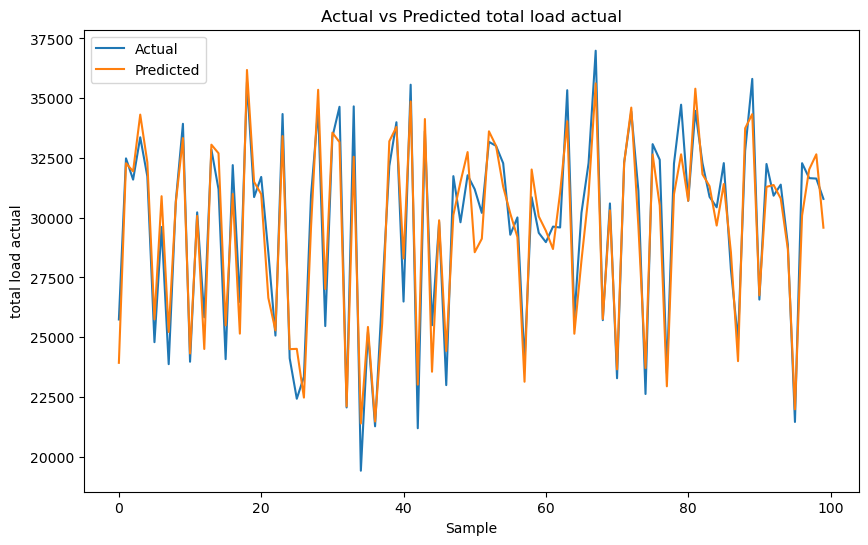

In [55]:
model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    
# Run the pipeline
train_and_evaluate(df_final, target, columns_to_exclude, model)

#### Linear Regression

Mean Squared Error: 1685473.7004861683
MAE score is: 1025.457213624882
RMSE score is: 1298.257948362408
R2_Score score is: 0.9191854237596012


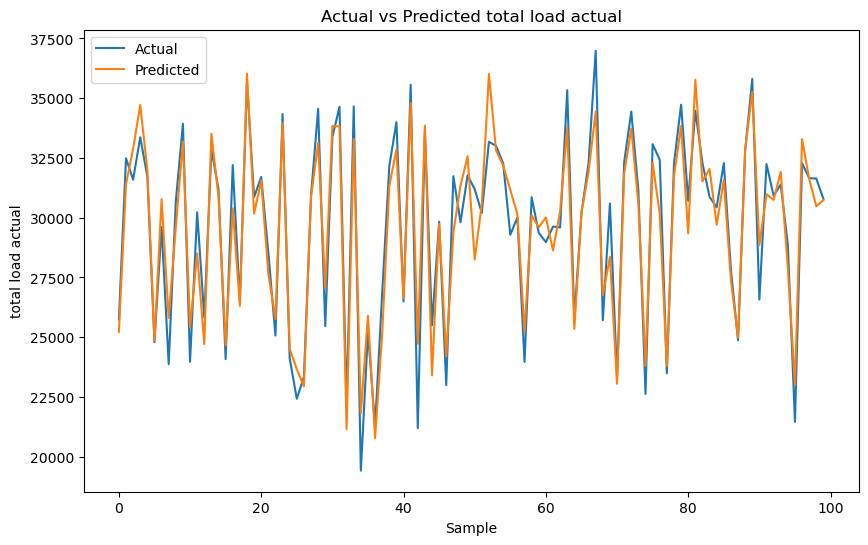

In [56]:
model = LinearRegression()

# Run the pipeline
train_and_evaluate(df_final, target, columns_to_exclude, model)

In [57]:
# polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
# X_polynomial = polynomial_features.fit_transform(df_final)

# model = LinearRegression()
# X_polynomial
# # Run the pipeline
# train_and_evaluate(X_polynomial, target, columns_to_exclude, model)

# # Prepare the data
# X, y = prepare_data(df_final, target, columns_to_exclude)

# # Apply Polynomial Features transformation
# degree = 2
# poly = PolynomialFeatures(degree=degree, include_bias=False)
# X_polynomial = poly.fit_transform(X)

# # Choose the model you want to use
# model = LinearRegression()  # Example model

# # Run the pipeline
# train_and_evaluate(X_polynomial, y, model)

### Polynomial

Mean Squared Error: 1083354.611525368
MAE score is: 798.4295128482024
RMSE score is: 1040.843221395695
R2_Score is: 0.9480556452329985


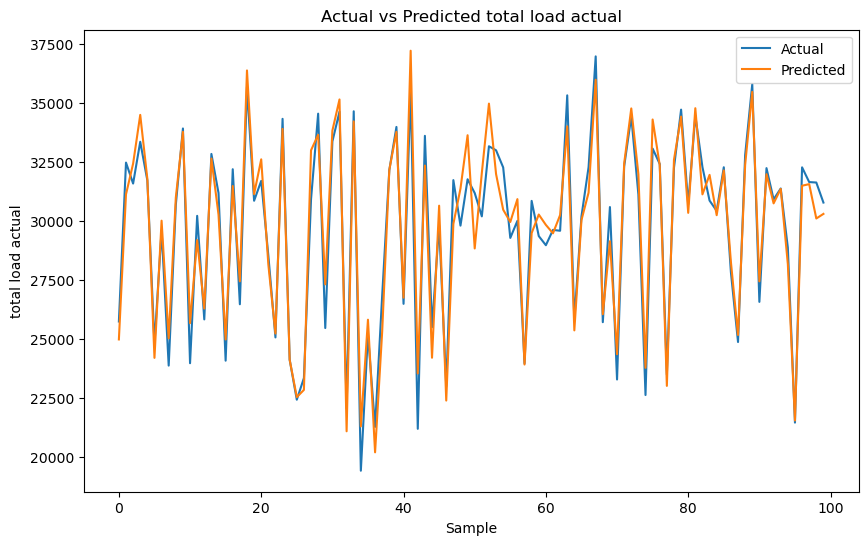

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def prepare_data(df, target, columns_to_exclude):
    """
    Prepare the data by excluding specified columns and splitting into features and target.
    
    Parameters:
    - df: DataFrame
    - target: str, the name of the target column
    - columns_to_exclude: list of str, columns to exclude from features
    
    Returns:
    - X: DataFrame, features
    - y: Series, target
    """
    # Drop 'time' column if present
    if 'time' in df.columns:
        df = df.drop(columns=['time'])
    
    # Dynamically select features by excluding the columns we don't need
    features = [col for col in df.columns if col not in columns_to_exclude + [target]]
    
    X = df[features]
    y = df[target]
    
    return X, y

def train_model(X_train, y_train, model):
    """
    Train the specified model.
    
    Parameters:
    - X_train: DataFrame, training features
    - y_train: Series, training target
    - model: an instantiated machine learning model
    
    Returns:
    - model: trained machine learning model
    """
    model.fit(X_train, y_train)
    return model

def evaluate_and_plot(X_test, y_test, model, target):
    """
    Evaluate the model and plot the actual vs predicted values.
    
    Parameters:
    - X_test: DataFrame, testing features
    - y_test: Series, testing target (actual values)
    - model: trained machine learning model
    - target: str, the name of the target column
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    MSE = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {MSE}')
    MAE = mean_absolute_error(y_test, y_pred)
    print(f'MAE score is: {MAE}')
    RMSE = np.sqrt(MSE)
    print(f'RMSE score is: {RMSE}')
    R2_Score = r2_score(y_test, y_pred)
    print(f'R2_Score is: {R2_Score}')
    
    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values[:100], label='Actual')
    plt.plot(y_pred[:100], label='Predicted')
    plt.xlabel('Sample')
    plt.ylabel(target)
    plt.title(f'Actual vs Predicted {target}')
    plt.legend()
    plt.show()

def train_and_evaluate(X, y, model):
    """
    Full pipeline: Split data, train model, and evaluate with plotting.
    
    Parameters:
    - X: DataFrame, features
    - y: Series, target
    - model: an instantiated machine learning model
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    trained_model = train_model(X_train, y_train, model)
    
    evaluate_and_plot(X_test, y_test, trained_model, target)

# Define the target variable and columns to exclude
target = 'total load actual'
columns_to_exclude = [
    'generation hydro pumped storage aggregated',
    'forecast wind offshore eday ahead',
]

# Prepare the data
X, y = prepare_data(df_final, target, columns_to_exclude)

# Apply Polynomial Features transformation
degree = 2
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_polynomial = poly.fit_transform(X)

# Choose the model you want to use
model = LinearRegression()  # Example model

# Run the pipeline
train_and_evaluate(X_polynomial, y, model)


In [ ]:
# Define the target variable and columns to exclude
target = 'total load actual'
columns_to_exclude = [
    'generation hydro pumped storage aggregated',
    'forecast wind offshore eday ahead',
]

# Prepare the data
X, y = prepare_data(df_final, target, columns_to_exclude)

# Apply Polynomial Features transformation
degree = 3
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_polynomial = poly.fit_transform(X)

# Choose the model you want to use
model = LinearRegression()  # Example model

# Run the pipeline
train_and_evaluate(X_polynomial, y, model)